In [1]:
import pandas as pd
import re

def parse_gtf(gtf_path):
    """
    Parse a GTF file and extract gene locations.

    Parameters:
        gtf_path (str): Path to the GTF file.

    Returns:
        pd.DataFrame: A DataFrame with columns ['gene_name', 'gene_id', 'chromosome', 'start', 'end']
    """

    # Load GTF file (skip comment lines)
    gtf = pd.read_csv(
        gtf_path,
        sep="\t",
        comment="#",
        header=None,
        names=[
            "chromosome", "source", "feature", "start", "end",
            "score", "strand", "frame", "attribute"
        ]
    )

    # Keep only 'gene' entries
    genes = gtf[gtf["feature"] == "gene"].copy()

    # Helper function to extract a specific attribute
    def extract_attr(attr_string, key):
        match = re.search(f'{key} "([^"]+)"', attr_string)
        return match.group(1) if match else None

    # Extract gene_name and gene_id
    genes["gene_name"] = genes["attribute"].apply(lambda x: extract_attr(x, "gene_name"))
    genes["gene_id"] = genes["attribute"].apply(lambda x: extract_attr(x, "gene_id"))

    # Return only needed columns
    return genes[["gene_name", "gene_id", "chrom", "start", "end"]].dropna()


In [2]:
# Install packages
!pip install scanpy scipy umap-learn leidenalg scFates
!pip install hmmlearn

In [3]:
import os, sys
os.environ['R_HOME'] = sys.exec_prefix+"/lib/R/"
import scanpy as sc
import scFates as scf
import numpy as np
import pandas as pd
from anndata import AnnData
from typing import Dict, Tuple
from hmmlearn import hmm
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt
from scipy.sparse import issparse

In [4]:
# Connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
adata_combined = sc.read("/content/drive/MyDrive/compscfiles/task3finalproject/somitoid_all_timepoints_combined_raw.h5ad")

In [6]:
adata_combined

AnnData object with n_obs × n_vars = 18716 × 33694
    obs: 'timepoint', 'original_batch'

In [7]:
# Basic inspection of the dataset
print(adata_combined)
print(f"Timepoints: {adata_combined.obs['timepoint'].unique()}")

# Create a backup layer for raw counts if it doesn't exist
if 'counts' not in adata_combined.layers:
    adata_combined.layers['counts'] = adata_combined.X.copy()

AnnData object with n_obs × n_vars = 18716 × 33694
    obs: 'timepoint', 'original_batch'
Timepoints: ['day1', 'day2', 'day3', 'day5']
Categories (4, object): ['day1', 'day2', 'day3', 'day5']


In [8]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re  # Add this import for regular expressions
from scipy.sparse import issparse
from typing import Dict, Tuple
from hmmlearn import hmm
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import warnings


def parse_gtf(gtf_path):
    """
    Parse a GTF file and extract gene locations.

    Parameters:
        gtf_path (str): Path to the GTF file.

    Returns:
        pd.DataFrame: A DataFrame with columns ['gene_name', 'gene_id', 'chromosome', 'start', 'end']
    """
    # Load GTF file (skip comment lines)
    gtf = pd.read_csv(
        gtf_path,
        sep="\t",
        comment="#",
        header=None,
        names=[
            "chromosome", "source", "feature", "start", "end",
            "score", "strand", "frame", "attribute"
        ]
    )

    # Keep only 'gene' entries
    genes = gtf[gtf["feature"] == "gene"].copy()

    # Helper function to extract a specific attribute
    def extract_attr(attr_string, key):
        match = re.search(f'{key} "([^"]+)"', attr_string)
        return match.group(1) if match else None

    # Extract gene_name and gene_id
    genes["gene_name"] = genes["attribute"].apply(lambda x: extract_attr(x, "gene_name"))
    genes["gene_id"] = genes["attribute"].apply(lambda x: extract_attr(x, "gene_id"))

    # Return only needed columns
    return genes[["gene_name", "gene_id", "chromosome", "start", "end"]].dropna()

# Update path to your GTF file
gtf_file = "/content/drive/MyDrive/compscfiles/gencode.v47.primary_assembly.annotation.gtf"
gene_df = parse_gtf(gtf_file)

print(f"Loaded {len(gene_df)} genes from GTF file")
print(gene_df.head())

Loaded 78932 genes from GTF file
      gene_name            gene_id chromosome  start    end
0      DDX11L16  ENSG00000290825.2       chr1  11121  24894
124     DDX11L1  ENSG00000223972.6       chr1  12010  13670
132      WASH7P  ENSG00000310526.1       chr1  14356  30744
2403     WASH7P  ENSG00000227232.6       chr1  14696  24886
2415  MIR6859-1  ENSG00000278267.1       chr1  17369  17436


In [9]:
# Add gene_name column
adata_combined.var["gene_name"] = adata_combined.var.index

# Remove duplicates from the GTF data
gene_df_unique = gene_df.drop_duplicates(subset="gene_name")

# Strip version numbers if needed
adata_combined.var["gene_name_stripped"] = adata_combined.var.index.str.replace(r"\.\d+$", "", regex=True)

# Merge genomic locations into adata.var
merged = adata_combined.var.merge(
    gene_df_unique,
    left_on="gene_name_stripped",
    right_on="gene_name",
    how="left",
    suffixes=("", "_gtf")
)

# Check how many genes have genomic locations
missing_count = merged["chromosome"].isna().sum()
print(f"{missing_count} genes are missing genomic locations ({missing_count/len(merged)*100:.1f}%)")

# Update adata.var with genomic locations
adata_combined.var = merged.set_index(adata_combined.var.index)

# Drop genes without genomic locations
adata_filtered = adata_combined[:, ~adata_combined.var["start"].isna()].copy()
print(f"Filtered adata shape: {adata_filtered.shape}")

26415 genes are missing genomic locations (78.4%)
Filtered adata shape: (18716, 7279)


day1: 2930 cells
day2: 4977 cells
day3: 5968 cells
day5: 4841 cells


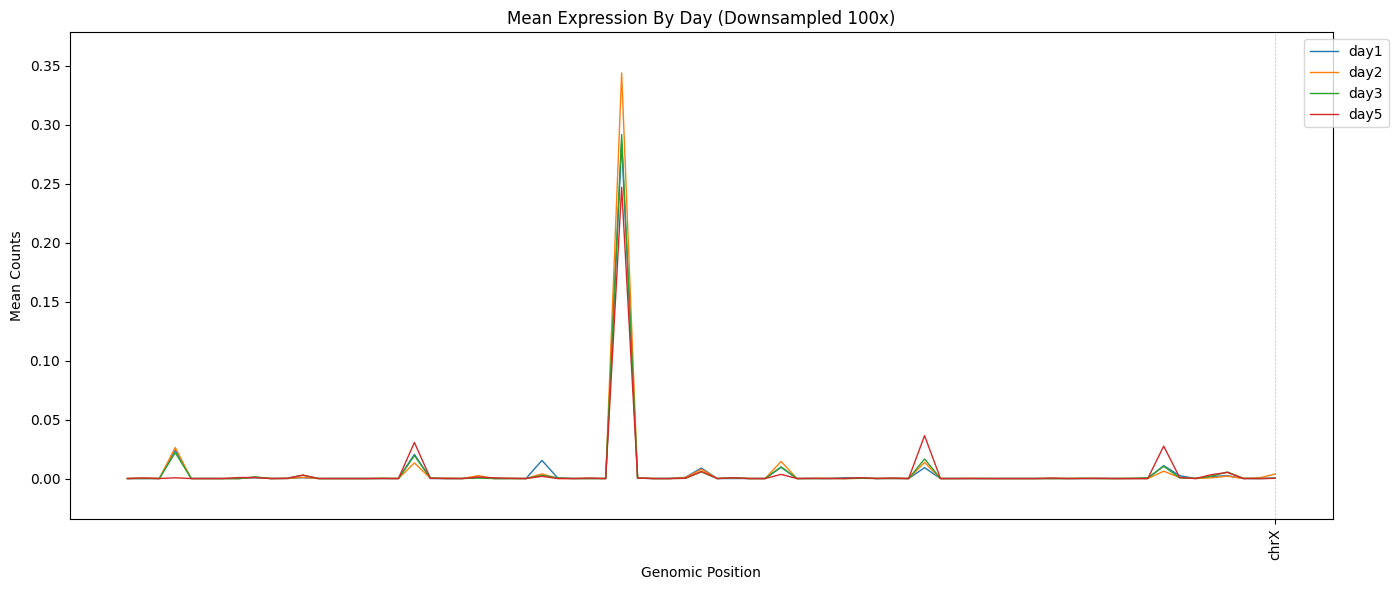

In [10]:
# Split by timepoint
adata_by_day = {}
for day in adata_filtered.obs["timepoint"].unique():
    adata_by_day[day] = adata_filtered[adata_filtered.obs["timepoint"] == day].copy()
    print(f"{day}: {adata_by_day[day].shape[0]} cells")

# Function to plot expression by genomic position to identify reference day
def plot_day_means_by_genomic_position(adata_by_day, layer="counts", downsample=100):
    """
    Plots mean expression across genomic positions for each day in the dataset.
    """
    # Get combined gene list ordered by genomic position
    all_vars = adata_filtered.var.sort_values(['chromosome', 'start'])
    gene_indices = np.arange(0, all_vars.shape[0], downsample)

    # Get chromosome info
    chromosomes = all_vars["chromosome"].values[gene_indices]

    valid_chroms = [str(i) for i in range(1, 23)] + ['X', 'Y', 'chrX', 'chrY']
    chrom_mask = np.isin(chromosomes, valid_chroms)
    chrom_changes = np.where((chromosomes[:-1] != chromosomes[1:]) &
                             (chrom_mask[:-1] | chrom_mask[1:]))[0] + 1
    chrom_boundaries = [0] + chrom_changes.tolist() + [len(chromosomes)]
    chrom_midpoints = [(chrom_boundaries[i] + chrom_boundaries[i+1]) // 2
                       for i in range(len(chrom_boundaries)-1)]
    chrom_labels = [chromosomes[i] for i in chrom_boundaries[:-1]]

    # Calculate global Y-axis limits
    all_means = []
    for day, day_adata in adata_by_day.items():
        day_genes = all_vars.index.intersection(day_adata.var_names)
        day_data = day_adata[:, day_genes].layers.get(layer, day_adata[:, day_genes].X)
        if issparse(day_data):
            day_data = day_data.toarray()

        # Calculate mean expression for downsampled genes
        day_means = np.zeros(len(gene_indices))
        for i, idx in enumerate(gene_indices):
            if idx < day_data.shape[1]:
                day_means[i] = np.mean(day_data[:, idx])

        all_means.append(day_means)

    global_ymin = min(np.min(means) for means in all_means if len(means) > 0)
    global_ymax = max(np.max(means) for means in all_means if len(means) > 0)
    y_padding = (global_ymax - global_ymin) * 0.1

    # Combined plot
    plt.figure(figsize=(14, 6))
    days = list(adata_by_day.keys())

    for i, (day, means) in enumerate(zip(days, all_means)):
        plt.plot(means, label=f"{day}", linewidth=1)

    # Add chromosome boundaries
    if chromosomes is not None:
        for x in chrom_boundaries[1:-1]:
            if x < len(chromosomes) and chrom_mask[x]:
                plt.axvline(x, color='gray', linestyle='--', alpha=0.5, linewidth=0.5)

        plt.xticks(
            [mp for mp, lbl in zip(chrom_midpoints, chrom_labels) if lbl in valid_chroms],
            [lbl for lbl in chrom_labels if lbl in valid_chroms],
            rotation=90
        )

    plt.ylim(global_ymin - y_padding, global_ymax + y_padding)
    plt.title(f"Mean Expression By Day (Downsampled {downsample}x)")
    plt.xlabel("Genomic Position")
    plt.ylabel("Mean Counts")
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.tight_layout()
    plt.show()

# Run plot function to identify the day with most stable expression
plot_day_means_by_genomic_position(adata_by_day, layer="counts", downsample=100)

In [11]:
def compute_smoothed_profiles(
    adata,
    use_layer=None,
    window_size=25,
    ref_day='day5'  # Modified to use day5 as reference
):
    """
    Computes smoothed expression profiles from an AnnData object.
    Uses day5 as the reference timepoint.
    """
    # Order genes
    adata_ordered = order_genes_by_position(adata)

    # Get expression matrix
    if use_layer:
        expr = pd.DataFrame(
            adata_ordered.layers[use_layer].toarray() if issparse(adata_ordered.layers[use_layer]) else adata_ordered.layers[use_layer],
            index=adata_ordered.obs_names,
            columns=adata_ordered.var_names
        )
    else:
        expr = pd.DataFrame(
            adata_ordered.X.toarray() if issparse(adata_ordered.X) else adata_ordered.X,
            index=adata_ordered.obs_names,
            columns=adata_ordered.var_names
        )

    # Smooth expression
    smoothed_expr = smooth_expression_matrix(expr, window_size)

    # Global average
    global_avg = smoothed_expr.mean(axis=0)

    # Per-timepoint averages
    timepoint_profiles = {}
    for tp in adata_ordered.obs['timepoint'].unique():
        tp_mask = adata_ordered.obs['timepoint'] == tp
        tp_expr = smoothed_expr.loc[tp_mask]
        timepoint_profiles[tp] = tp_expr.mean(axis=0)

    # Reference timepoint average - using day5
    if ref_day in timepoint_profiles:
        ref_avg = timepoint_profiles[ref_day]
    else:
        raise ValueError(f"Reference timepoint '{ref_day}' not found.")

    return smoothed_expr, timepoint_profiles, global_avg, ref_avg

In [12]:
def order_genes_by_position(adata):
    """Orders the variables (genes) in the AnnData object by chromosome and start."""
    gene_order = (
        adata.var
        .sort_values(['chromosome', 'start'])
        .index
    )
    return adata[:, gene_order]

def smooth_expression_matrix(matrix, window_size=25):
    """Applies a sliding window average across genes."""
    smoothed = []
    gene_names = matrix.columns.to_list()
    for i in range(len(gene_names) - window_size + 1):
        window = gene_names[i:i + window_size]
        avg_expr = matrix[window].mean(axis=1)
        smoothed.append(avg_expr.rename(f"{window[0]}_to_{window[-1]}"))
    return pd.concat(smoothed, axis=1)

def compute_smoothed_profiles(
    adata,
    use_layer=None,
    window_size=25,
    ref_day='day5'  # Using day5 as reference
):
    """
    Computes smoothed expression profiles from an AnnData object.
    Uses day5 as the reference timepoint.
    """
    # Order genes
    adata_ordered = order_genes_by_position(adata)

    # Get expression matrix
    if use_layer:
        expr = pd.DataFrame(
            adata_ordered.layers[use_layer].toarray() if issparse(adata_ordered.layers[use_layer]) else adata_ordered.layers[use_layer],
            index=adata_ordered.obs_names,
            columns=adata_ordered.var_names
        )
    else:
        expr = pd.DataFrame(
            adata_ordered.X.toarray() if issparse(adata_ordered.X) else adata_ordered.X,
            index=adata_ordered.obs_names,
            columns=adata_ordered.var_names
        )

    # Smooth expression
    smoothed_expr = smooth_expression_matrix(expr, window_size)

    # Global average
    global_avg = smoothed_expr.mean(axis=0)

    # Per-timepoint averages
    timepoint_profiles = {}
    for tp in adata_ordered.obs['timepoint'].unique():
        tp_mask = adata_ordered.obs['timepoint'] == tp
        tp_expr = smoothed_expr.loc[tp_mask]
        timepoint_profiles[tp] = tp_expr.mean(axis=0)

    # Reference timepoint average
    if ref_day in timepoint_profiles:
        ref_avg = timepoint_profiles[ref_day]
    else:
        raise ValueError(f"Reference timepoint '{ref_day}' not found.")

    return smoothed_expr, timepoint_profiles, global_avg, ref_avg

In [13]:
# Apply smoothing and calculate profiles
smoothed, timepoint_avg, global_avg, ref_avg = compute_smoothed_profiles(
    adata_filtered,
    use_layer='counts',
    window_size=25,
    ref_day='day5'  # Explicitly specifying day5 as reference
)

In [14]:
def compute_z_scores(smoothed, timepoint_avg, global_avg, ref_avg, adata):
    """Calculate z-scores against different references."""

    print("Computing z-scores relative to day5 reference...")
    cells = smoothed.index
    genes = smoothed.columns

    # Convert to numpy arrays for faster processing
    smoothed_np = smoothed.values
    global_avg_np = global_avg.values
    ref_avg_np = ref_avg.values

    # Get timepoint for each cell
    cell_timepoints = adata.obs.loc[cells, 'timepoint'].values
    timepoint_avg_np = np.zeros_like(smoothed_np)

    # Fill in timepoint averages for each cell
    for i, tp in enumerate(cell_timepoints):
        timepoint_avg_np[i] = timepoint_avg[tp].values

    # Calculate deltas
    delta_global = smoothed_np - global_avg_np
    delta_timepoint = smoothed_np - timepoint_avg_np
    delta_ref = smoothed_np - ref_avg_np

    # Z-score normalize each row (cell)
    def zscore_rowwise(matrix):
        mean = matrix.mean(axis=1, keepdims=True)
        std = matrix.std(axis=1, keepdims=True)
        std[std == 0] = 1  # prevent division by zero
        return (matrix - mean) / std

    print("Normalizing z-scores...")
    delta_global_z = zscore_rowwise(delta_global)
    delta_timepoint_z = zscore_rowwise(delta_timepoint)
    delta_ref_z = zscore_rowwise(delta_ref)

    # Store in adata
    adata.obsm['delta_global_z'] = delta_global_z
    adata.obsm['delta_timepoint_z'] = delta_timepoint_z
    adata.obsm['delta_ref_z'] = delta_ref_z
    adata.uns['delta_zscore_genes'] = list(genes)

    print("Z-scores calculated and stored in adata.obsm")
    return adata

# Apply z-score calculation
adata_filtered = compute_z_scores(smoothed, timepoint_avg, global_avg, ref_avg, adata_filtered)

Computing z-scores relative to day5 reference...
Normalizing z-scores...
Z-scores calculated and stored in adata.obsm


In [15]:
def compute_z_scores(smoothed, timepoint_avg, global_avg, ref_avg, adata):
    """Calculate z-scores against different references."""

    print("Computing z-scores relative to day5 reference...")
    cells = smoothed.index
    genes = smoothed.columns

    # Convert to numpy arrays for faster processing
    smoothed_np = smoothed.values
    global_avg_np = global_avg.values
    ref_avg_np = ref_avg.values

    # Get timepoint for each cell
    cell_timepoints = adata.obs.loc[cells, 'timepoint'].values
    timepoint_avg_np = np.zeros_like(smoothed_np)

    # Fill in timepoint averages for each cell
    for i, tp in enumerate(cell_timepoints):
        timepoint_avg_np[i] = timepoint_avg[tp].values

    # Calculate deltas
    delta_global = smoothed_np - global_avg_np
    delta_timepoint = smoothed_np - timepoint_avg_np
    delta_ref = smoothed_np - ref_avg_np

    # Z-score normalize each row (cell)
    def zscore_rowwise(matrix):
        mean = matrix.mean(axis=1, keepdims=True)
        std = matrix.std(axis=1, keepdims=True)
        std[std == 0] = 1  # prevent division by zero
        return (matrix - mean) / std

    print("Normalizing z-scores...")
    delta_global_z = zscore_rowwise(delta_global)
    delta_timepoint_z = zscore_rowwise(delta_timepoint)
    delta_ref_z = zscore_rowwise(delta_ref)

    # Store in adata
    adata.obsm['delta_global_z'] = delta_global_z
    adata.obsm['delta_timepoint_z'] = delta_timepoint_z
    adata.obsm['delta_ref_z'] = delta_ref_z
    adata.uns['delta_zscore_genes'] = list(genes)

    print("Z-scores calculated and stored in adata.obsm")
    return adata

# Apply z-score calculation
adata_filtered = compute_z_scores(smoothed, timepoint_avg, global_avg, ref_avg, adata_filtered)

Computing z-scores relative to day5 reference...
Normalizing z-scores...
Z-scores calculated and stored in adata.obsm


In [16]:
def filter_zscores(zscore_array, upper_thresh=1.5, lower_thresh=-1.5, min_cells=100, adata=None, obsm_key=None):
    """Filter z-scores to identify significant changes."""

    print("Filtering z-scores to find significant changes...")
    # Convert to DataFrame with proper indexing
    zscore_df = pd.DataFrame(
        zscore_array,
        index=adata.obs_names if adata else None,
        columns=adata.uns['delta_zscore_genes'] if adata and 'delta_zscore_genes' in adata.uns else None
    )

    # Create significance masks
    sig_mask = (zscore_df > upper_thresh) | (zscore_df < lower_thresh)
    sig_counts = sig_mask.sum(axis=0)  # Count per gene

    # Filter genes
    keep_genes = sig_counts >= min_cells
    filtered_df = zscore_df.loc[:, keep_genes]

    # Store in AnnData if requested
    if adata is not None and obsm_key is not None:
        # Create filtered matrix
        filtered_matrix = np.zeros((adata.n_obs, len(zscore_df.columns)))
        filtered_matrix.fill(np.nan)  # Fill with NaN initially

        # Find indices of kept genes
        kept_indices = np.where(keep_genes)[0]

        # Fill only the significant genes
        filtered_matrix[:, kept_indices] = zscore_df.iloc[:, kept_indices].values

        # Store in adata
        adata.obsm[obsm_key] = filtered_matrix
        adata.uns[f"{obsm_key}_genes"] = filtered_df.columns.tolist()

    # Count significant events
    up_counts = (zscore_df > upper_thresh).sum(axis=0)
    down_counts = (zscore_df < lower_thresh).sum(axis=0)

    print(f"Filtered to {keep_genes.sum()} genes with changes in ≥{min_cells} cells")
    return filtered_df, up_counts, down_counts, adata

# Filter z-scores - adjust min_cells based on your dataset size
filtered_df, up_counts, down_counts, adata_filtered = filter_zscores(
    adata_filtered.obsm["delta_ref_z"],
    upper_thresh=1.5,
    lower_thresh=-1.5,
    min_cells=100,  # You might need to adjust this based on your dataset size
    adata=adata_filtered,
    obsm_key="filtered_ref_z"
)

Filtering z-scores to find significant changes...
Filtered to 7006 genes with changes in ≥100 cells


In [17]:
def detect_cnvs_with_hmm_fixed(adata, matrix_name="filtered_ref_z", n_components=3,
                         n_iter=30, random_state=42, output_prefix="hmm_cnv",
                         min_non_nan=20, chunk_size=50):
    """
    Fixed HMM implementation for CNV detection that handles index length mismatches
    """
    if matrix_name not in adata.obsm:
        raise ValueError(f"Matrix '{matrix_name}' not found in adata.obsm")

    data = adata.obsm[matrix_name]
    n_cells, n_features = data.shape

    print(f"Matrix shape: {n_cells} cells x {n_features} features")
    print(f"adata.var shape: {adata.var.shape}")

    # Make sure we're only processing features that exist in both the matrix and adata.var
    if 'delta_zscore_genes' in adata.uns:
        feature_names = adata.uns['delta_zscore_genes']
        if len(feature_names) != n_features:
            print(f"Warning: Feature count mismatch. Matrix has {n_features} features but feature_names has {len(feature_names)}")
            # Trim to shorter length
            feature_names = feature_names[:min(len(feature_names), n_features)]
            n_features = len(feature_names)
    else:
        print("Warning: No feature names found in adata.uns['delta_zscore_genes']")
        feature_names = adata.var_names[:n_features]

    # Initialize arrays for states and posteriors
    all_states = np.full(n_features, -1, dtype=np.int8)
    all_posteriors = np.full((n_features, n_components), np.nan, dtype=np.float16)

    # Find valid features (genes with sufficient non-NaN values)
    print("Identifying valid features...")
    valid_features = []
    for f in range(n_features):
        non_nan_count = np.sum(~np.isnan(data[:, f]))
        if non_nan_count >= min_non_nan:
            valid_features.append(f)

    print(f"Found {len(valid_features)} valid features out of {n_features}")

    if len(valid_features) < n_components:
        raise ValueError(f"Only {len(valid_features)} valid features found - need at least {n_components} for HMM")

    # Use smaller chunks
    chunk_size = min(chunk_size, len(valid_features) // 10 + 1)

    # Initialize HMM model
    model = hmm.GaussianHMM(
        n_components=n_components,
        covariance_type="diag",
        n_iter=n_iter,
        random_state=random_state
    )

    model_fitted = False

    # Process in chunks with better error handling
    print(f"Processing in chunks of size {chunk_size}...")
    for chunk_start in range(0, len(valid_features), chunk_size):
        chunk_end = min(chunk_start + chunk_size, len(valid_features))
        chunk_features = valid_features[chunk_start:chunk_end]
        print(f"Processing chunk {chunk_start//chunk_size+1}/{(len(valid_features)-1)//chunk_size+1}...")

        try:
            # Extract chunk data
            chunk = data[:, chunk_features]

            # Find cells with complete data for this chunk
            valid_cells = ~np.isnan(chunk).any(axis=1)
            valid_cell_count = np.sum(valid_cells)

            if valid_cell_count < min_non_nan:
                print(f"  Skipping chunk - only {valid_cell_count} valid cells (need {min_non_nan})")
                continue

            print(f"  Processing with {valid_cell_count} valid cells")
            clean_chunk = chunk[valid_cells, :]

            # Standardize chunk for HMM
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                scaler = StandardScaler()
                scaled_chunk = scaler.fit_transform(clean_chunk)
                scaled_chunk = np.nan_to_num(scaled_chunk)

            # Fit model on first valid chunk
            if not model_fitted:
                model.fit(scaled_chunk.T)
                model_fitted = True
                print("  Model successfully fitted!")

            # Predict states and posteriors for this chunk
            states = model.predict(scaled_chunk.T)
            posteriors = model.predict_proba(scaled_chunk.T)

            # Store results for this chunk
            for i, f in enumerate(chunk_features):
                all_states[f] = states[i]
                all_posteriors[f] = posteriors[i].astype(np.float16)

        except Exception as e:
            print(f"  Error processing chunk: {str(e)}")
            import gc
            gc.collect()
            continue

    if not model_fitted:
        raise RuntimeError("Could not fit HMM to any data chunks")

    # Create a new DataFrame with results to avoid length mismatch
    print("Storing HMM results in adata.var...")

    # Create temporary columns for results
    state_col = f"{output_prefix}_state"
    prob_cols = [f"{output_prefix}_prob_state_{i}" for i in range(n_components)]

    # Create new columns if they don't exist
    for col in [state_col] + prob_cols:
        if col not in adata.var:
            adata.var[col] = -1 if col == state_col else np.nan

    # Update only the genes that were processed
    for i, gene_name in enumerate(feature_names):
        if gene_name in adata.var.index:
            adata.var.loc[gene_name, state_col] = all_states[i]
            for j in range(n_components):
                adata.var.loc[gene_name, prob_cols[j]] = all_posteriors[i, j]

    print("Stored HMM states and posteriors in adata.var")

    # Count states
    states, counts = np.unique(all_states[all_states >= 0], return_counts=True)
    for state, count in zip(states, counts):
        print(f"  State {state}: {count} genes ({count/n_features*100:.1f}%)")

    return adata

In [18]:
# Run the fixed HMM implementation
adata_filtered = detect_cnvs_with_hmm_fixed(
    adata_filtered,
    matrix_name="filtered_ref_z",
    n_components=3,  # 3 states: deletion, neutral, amplification
    n_iter=30,
    random_state=42,
    output_prefix="hmm_cnv",
    chunk_size=10
)

Matrix shape: 18716 cells x 7255 features
adata.var shape: (7279, 7)
Identifying valid features...
Found 7006 valid features out of 7255
Processing in chunks of size 10...
Processing chunk 1/701...
  Processing with 18716 valid cells
  Model successfully fitted!
Processing chunk 2/701...
  Processing with 18716 valid cells
Processing chunk 3/701...
  Processing with 18716 valid cells
Processing chunk 4/701...
  Processing with 18716 valid cells
Processing chunk 5/701...
  Processing with 18716 valid cells
Processing chunk 6/701...
  Processing with 18716 valid cells
Processing chunk 7/701...
  Processing with 18716 valid cells
Processing chunk 8/701...
  Processing with 18716 valid cells
Processing chunk 9/701...
  Processing with 18716 valid cells
Processing chunk 10/701...
  Processing with 18716 valid cells
Processing chunk 11/701...
  Processing with 18716 valid cells
Processing chunk 12/701...
  Processing with 18716 valid cells
Processing chunk 13/701...
  Processing with 18716 v

In [19]:
# Format the CNV results
adata_filtered, cnv_stats = format_detected_cnvs(
    adata_filtered,
    state_col='hmm_cnv_state',
    max_gap=500000,
    min_region_size=5000,
    z_threshold=1.0
)

NameError: name 'format_detected_cnvs' is not defined